# High-Throughput Proxy Viscometer
##### Author: Beatrice Soh

In [2]:
import pandas as pd 
import numpy as np 
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from sklearn.metrics import r2_score
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import svm
from scipy import stats
from scipy.integrate import cumtrapz, solve_ivp
from scipy.optimize import fsolve, curve_fit, differential_evolution

plt.rcParams.update({'font.size': 20})
matplotlib.rc('xtick', labelsize=15) 
matplotlib.rc('ytick', labelsize=15) 

### List viscosity standards and flowrates

In [3]:
# Define viscosity standards and flow rates
Viscosity_Standards = [28.5,99.8,204.8,398.4,505.4,817.4,1021,1275,1525,1925,2096,2375,2615,3032,3083,3405,3792,3941,4804,4928,5095,5291,5464,5882,5921,6033,6226,6695,6698,6813,7000,7782,7982,8254,9002,9884,11469,14023,15901,20962]
flowrates = [10,20,50,65,80]

total_num = len(Viscosity_Standards)
total_flowrates = list(np.repeat(flowrates,total_num))

# Create list of data file names
data_files = [f'MassProfile_{visc}cP_{FR}' for FR in flowrates for visc in Viscosity_Standards]

### Import data and fit to sigmoid curves

In [4]:
# Sigmoid function for fitting
def Sigmoid_3P(x, h, s, m):
    y = h/(1+np.exp(-(x-m)/s))
    return y

In [5]:
# Function to fit the volume data to the sigmoid function
def volume_fit(data):
    sample = pd.read_csv(data)
    time = sample['Time']
    volumes = [sample[f'Volume{i+1}'] * 1000 for i in range(5)]  # Convert from mL to µL
    
    init_guess = [100., 15., 1.]  # Initial guess for fitting
    fit_params = {'h': [], 's': [], 'm': [], 'r2': [], 'fit_sample': []}
    
    for volume in volumes:
        # Fit the model
        params, _ = curve_fit(Sigmoid_3P, time, volume, p0=init_guess,
                              bounds=((0., 0., 0.), (800., 30., 50.)), method='trf', maxfev=100000)
        
        h, s, m = params
        prediction = Sigmoid_3P(time, h, s, m)
        
        # Store parameters and fit results
        fit_params['h'].append(h)
        fit_params['s'].append(s)
        fit_params['m'].append(m)
        fit_params['fit_sample'].append(prediction)
        fit_params['r2'].append(r2_score(volume, prediction))
    
    return fit_params, time, volumes

In [6]:
# Initialize lists to store results
h, s, m, r2, fit_models, volume, time = [], [], [], [], [], [], []

# Loop through each data file and apply the fitting function
for data in data_files:
    fit_params, fit_time, fit_volumes = volume_fit(f'MassProfile_Total/{data}.csv')
    
    h.append(fit_params['h'])
    s.append(fit_params['s'])
    m.append(fit_params['m'])
    r2.append(fit_params['r2'])
    fit_models.append(fit_params['fit_sample'])
    volume.append(fit_volumes)
    time.append(fit_time)

# Calculate mean and standard deviation of the fit parameters
h_avg, h_std = np.mean(h, axis=1), np.std(h, axis=1)
s_avg, s_std = np.mean(s, axis=1), np.std(s, axis=1)
m_avg, m_std = np.mean(m, axis=1), np.std(m, axis=1)
r2_avg, r2_std = np.mean(r2, axis=1), np.std(r2, axis=1)

# Transpose for easier access to individual flows
h, s, m, r2 = map(np.transpose, [h, s, m, r2])

# Prepare data for dataframe
results_dict = {
    'File': data_files,
    'Flowrate (uL/s)': list(np.repeat(flowrates, total_num)),
    'Viscosity (cP)': Viscosity_Standards * len(flowrates),
    '$h_1$': np.round(h[0], 3), '$h_2$': np.round(h[1], 3), '$h_3$': np.round(h[2], 3),
    '$h_4$': np.round(h[3], 3), '$h_5$': np.round(h[4], 3), '$h_{avg}$': np.round(h_avg, 3),
    '$s_1$': np.round(s[0], 3), '$s_2$': np.round(s[1], 3), '$s_3$': np.round(s[2], 3),
    '$s_4$': np.round(s[3], 3), '$s_5$': np.round(s[4], 3), '$s_{avg}$': np.round(s_avg, 3),
    '$m_1$': np.round(m[0], 3), '$m_2$': np.round(m[1], 3), '$m_3$': np.round(m[2], 3),
    '$m_4$': np.round(m[3], 3), '$m_5$': np.round(m[4], 3), '$m_{avg}$': np.round(m_avg, 3),
    '$R^2_1$': np.round(r2[0], 3), '$R^2_2$': np.round(r2[1], 3), '$R^2_3$': np.round(r2[2], 3),
    '$R^2_4$': np.round(r2[3], 3), '$R^2_5$': np.round(r2[4], 3), '$R^2_{avg}$': np.round(r2_avg, 3)
}

# Create a dataframe from the results dictionary
results = pd.DataFrame(results_dict)

# Split the results into different flow rates
results_flow_dict = {
    10: results[results['Flowrate (uL/s)'] == 10],
    20: results[results['Flowrate (uL/s)'] == 20],
    50: results[results['Flowrate (uL/s)'] == 50],
    65: results[results['Flowrate (uL/s)'] == 65],
    80: results[results['Flowrate (uL/s)'] == 80]
}

### Plot dispense curves for all flowrates

In [7]:
# Plotting function
def plot_viscosities(start, end, results, title):
    color = iter(cm.viridis(np.linspace(0, 1, total_num)))  
    indices = np.linspace(start, end-1, total_num, dtype=int)  
    for i in indices:
        c = next(color)
        volume_avg = np.mean(volume[i], axis=0)
        plt.plot(time[i], volume_avg, color=c, label=f"{results['Viscosity (cP)'].iloc[i-start]} cP")
    plt.xlim([0,40])
    plt.xlabel('$t$ /s')
    plt.ylabel('$V$ /$\mu$L')
    plt.legend(loc='right', bbox_to_anchor=(1.5, 0.5), ncol = 2, fontsize=8)
    plt.title(title,fontsize=15)
    plt.show()

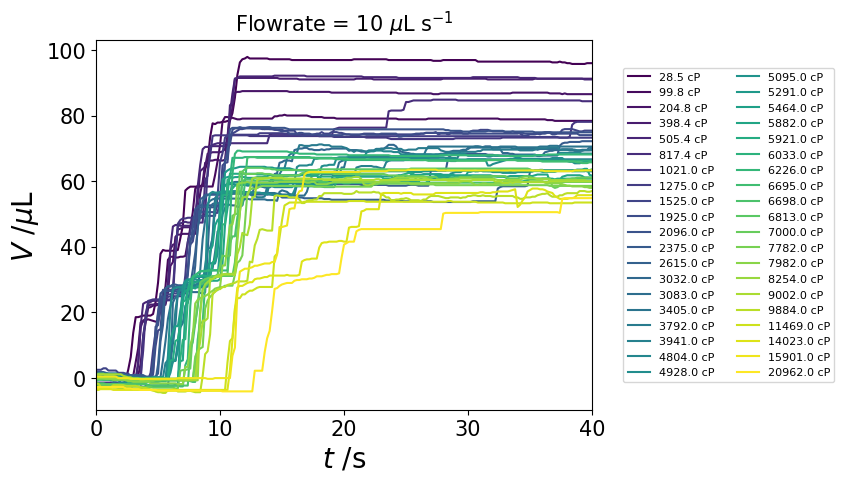

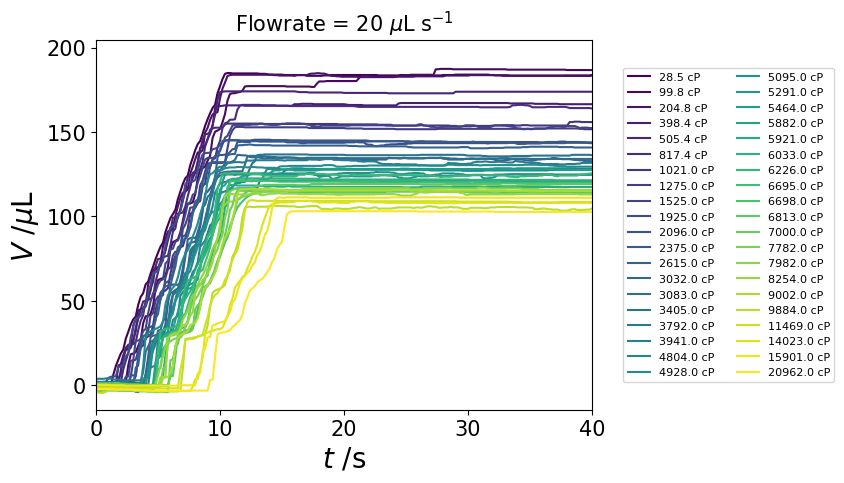

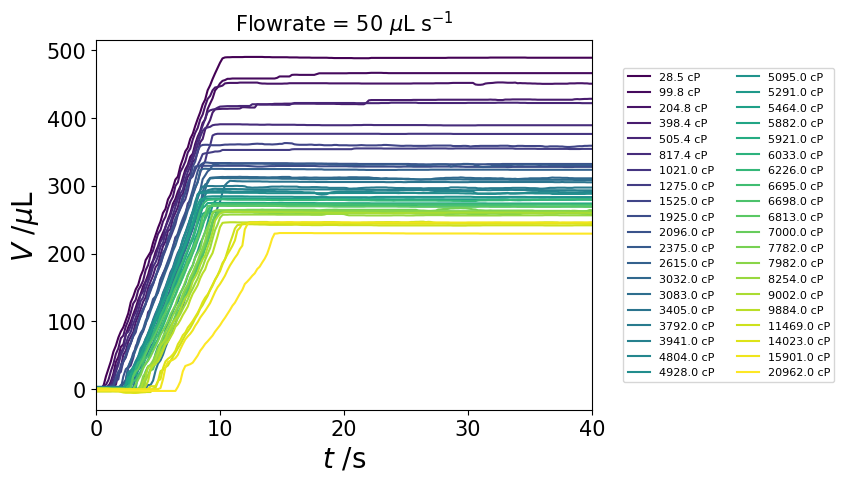

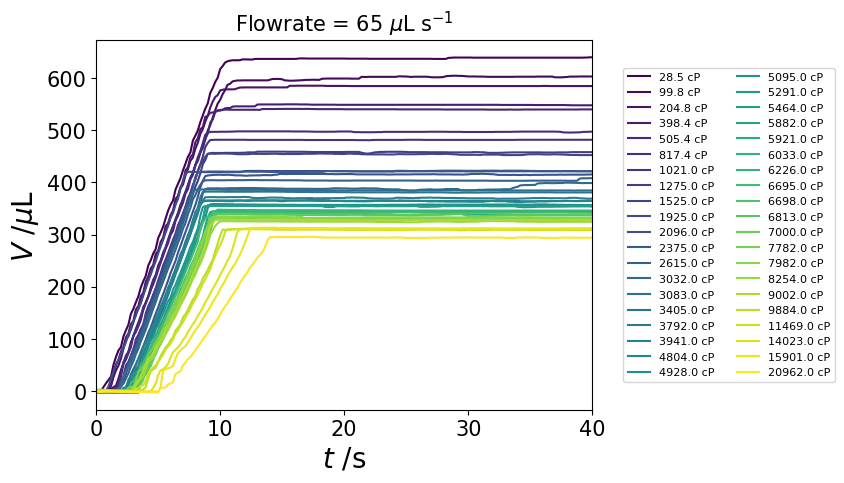

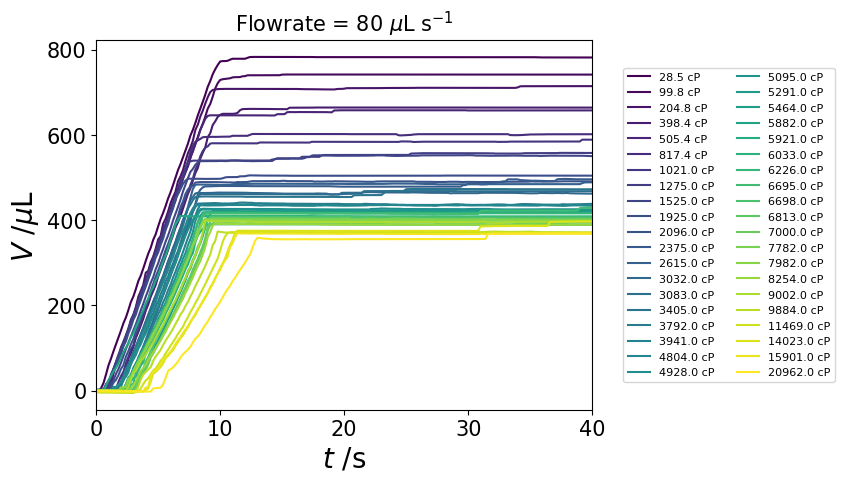

In [8]:
# Plot viscosities for each flow rate using the updated results_flow_dict
for i, flow in enumerate(np.array(flowrates)):
    start_idx = total_num * i
    end_idx = total_num * (i + 1)
    plot_viscosities(start_idx, end_idx, results_flow_dict[flow], f'Flowrate = {flow} $\mu$L s$^{{-1}}$')

### Plot fitted parameters for all flowrates

In [9]:
# Plot function for error bars
def plot_with_errorbars(x_data, y_data, ci, label, xlabel, ylabel, color):
    for i in range(5):
        plt.errorbar(x_data[i], y_data[i], yerr=ci[i], fmt='.', color=color[i], markersize=12)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(label, fontsize=15)
    plt.show()

In [10]:
# Determine 95% confidence intervals
h_se = h_std / np.sqrt(total_num)
s_se = s_std / np.sqrt(total_num)
m_se = m_std / np.sqrt(total_num)

t_val = stats.t.ppf(1 - 0.05 / 2, total_num - 1)

h_ci = h_se * t_val
s_ci = s_se * t_val
m_ci = m_se * t_val

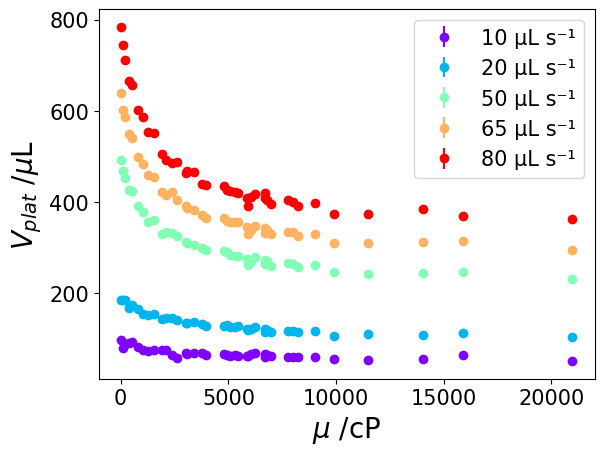

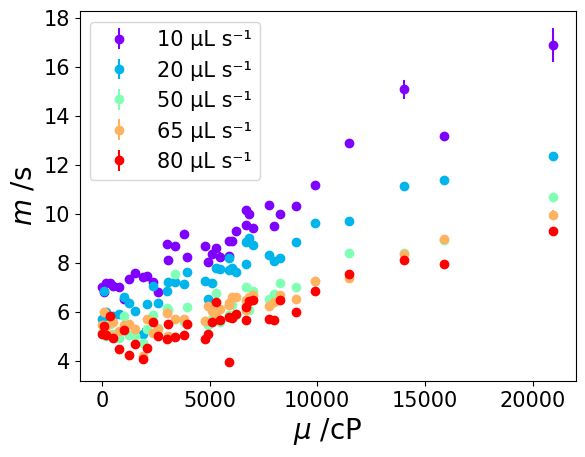

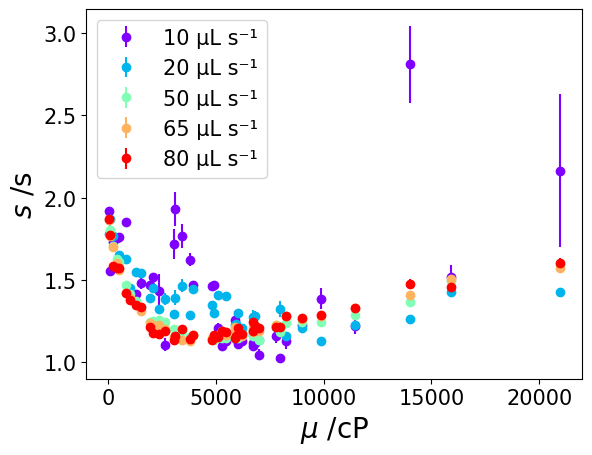

In [11]:
# Prepare data
viscosities = [
    results_flow_dict[10]['Viscosity (cP)'].to_numpy(float), 
    results_flow_dict[20]['Viscosity (cP)'].to_numpy(float),
    results_flow_dict[50]['Viscosity (cP)'].to_numpy(float), 
    results_flow_dict[65]['Viscosity (cP)'].to_numpy(float), 
    results_flow_dict[80]['Viscosity (cP)'].to_numpy(float)
]

color = cm.rainbow(np.linspace(0, 1, 5))
flowrate_labels = ['10 μL s⁻¹', '20 μL s⁻¹', '50 μL s⁻¹', '65 μL s⁻¹', '80 μL s⁻¹']

# Plot h (plateau height)
plot_with_errorbars(viscosities, [
    results_flow_dict[10]['$h_{avg}$'], results_flow_dict[20]['$h_{avg}$'], results_flow_dict[50]['$h_{avg}$'], 
    results_flow_dict[65]['$h_{avg}$'], results_flow_dict[80]['$h_{avg}$']
], h_ci.reshape(5, total_num), flowrate_labels, '$\mu$ /cP', '$V_{plat}$ /$\mu$L', color)

# Plot m (time shift)
plot_with_errorbars(viscosities, [
    results_flow_dict[10]['$m_{avg}$'], results_flow_dict[20]['$m_{avg}$'], results_flow_dict[50]['$m_{avg}$'], 
    results_flow_dict[65]['$m_{avg}$'], results_flow_dict[80]['$m_{avg}$']
], m_ci.reshape(5, total_num), flowrate_labels, '$\mu$ /cP', '$m$ /s', color)

# Plot s (steepness)
plot_with_errorbars(viscosities, [
    results_flow_dict[10]['$s_{avg}$'], results_flow_dict[20]['$s_{avg}$'], results_flow_dict[50]['$s_{avg}$'], 
    results_flow_dict[65]['$s_{avg}$'], results_flow_dict[80]['$s_{avg}$']
], s_ci.reshape(5, total_num), flowrate_labels, '$\mu$ /cP', '$s$ /s', color)

### Regression model to predict viscosity of Newtonian liquids

##### Pre-process data

In [12]:
# Initialize dictionaries to store data
X_scaled_dict = {}
y_dict = {}
log_y_dict = {}
train_test_data = {}

# Data preprocessing and split for each flow rate
bins = [0, 7.2, 8.2, 8.68, 8.96]
for flow in flowrates:
    # Extract relevant columns from the results dictionary
    df = results_flow_dict[flow][['Viscosity (cP)', '$h_{avg}$', '$s_{avg}$', '$m_{avg}$']]
    
    # Prepare feature matrix (X) and target vector (y)
    X = df.drop(['Viscosity (cP)'], axis=1).to_numpy()
    y = pd.to_numeric(df['Viscosity (cP)']).to_numpy(float)
    log_y = np.log(y)
    
    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Store scaled features and target vectors in dictionaries
    X_scaled_dict[flow] = X_scaled
    y_dict[flow] = y
    log_y_dict[flow] = log_y
    
    # Bin viscosities for stratified split using log_y of flow 10 for stratification
    if flow == 10:
        y_binned = np.digitize(log_y, bins)
    
    # Split datasets into training and testing sets
    train_X, test_X, train_y, test_y = train_test_split(
        X_scaled, log_y, stratify=y_binned, test_size=0.25, random_state=10
    )
    train_test_data[flow] = (train_X, test_X, train_y, test_y)

##### Train SVR model on individual flowrate datasets

In [13]:
# Flowrate-specific regressors
regressors = {
    10: svm.SVR(C=13.97, gamma=0.021),
    20: svm.SVR(C=595.96, gamma=0.002),
    50: svm.SVR(C=553.21, gamma=0.034),
    65: svm.SVR(C=567.84, gamma=0.003),
    80: svm.SVR(C=2409.09, gamma=0.002)
}

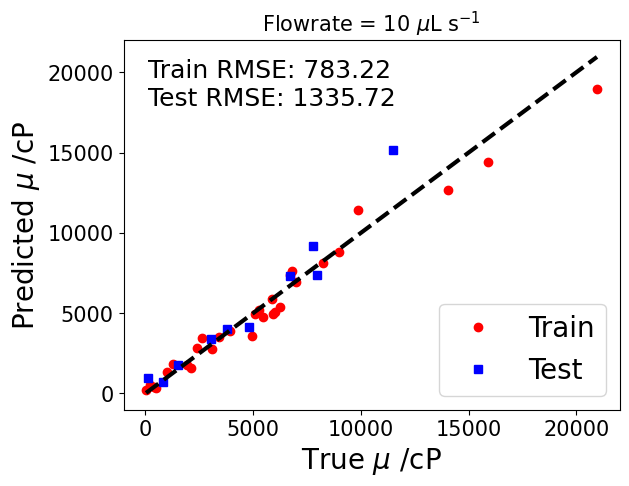

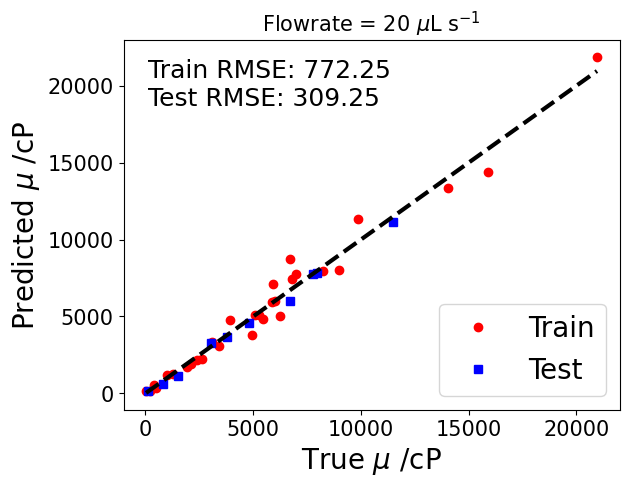

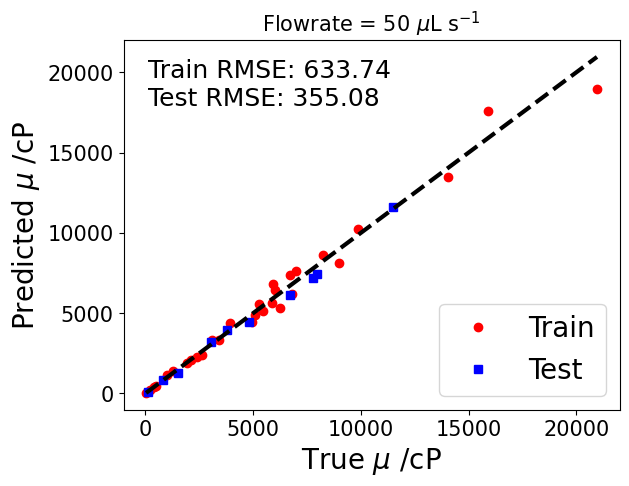

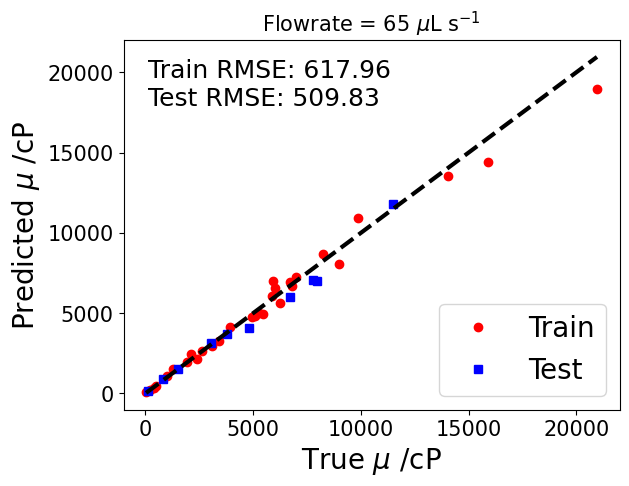

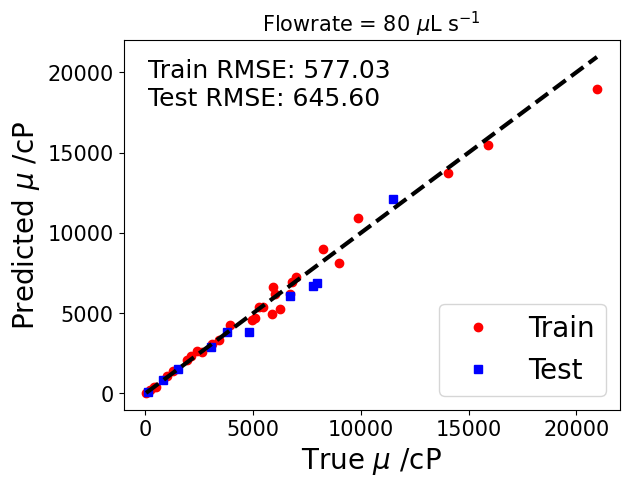

In [14]:
# Train models, predict, and calculate metrics for each flow rate
results = {}
colors = cm.rainbow(np.linspace(0, 1, len(flowrates)))

for idx, flow in enumerate(flowrates):
    train_X, test_X, train_y, test_y = train_test_data[flow]
    regressor = regressors[flow]
    
    # Fit the regressor and make predictions
    regressor.fit(train_X, train_y)
    train_predictions = regressor.predict(train_X)
    test_predictions = regressor.predict(test_X)
    
    # Compute MSE and RMSE
    train_mse = metrics.mean_squared_error(np.exp(train_y), np.exp(train_predictions))
    test_mse = metrics.mean_squared_error(np.exp(test_y), np.exp(test_predictions))
    train_rmse = np.sqrt(train_mse)
    test_rmse = np.sqrt(test_mse)
    
    # Store results
    results[flow] = {
        'train_predictions': train_predictions,
        'test_predictions': test_predictions,
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'color': colors[idx],
        'marker': ['p', 'd', 'v', '^', 'P'][idx]
    }
    
    # Plot individual prediction curves
    plt.plot(np.exp(train_y), np.exp(train_predictions.astype(np.float64)), 'r.', markersize=12)
    plt.plot(np.exp(test_y), np.exp(test_predictions.astype(np.float64)), 'bs')
    plt.plot([y_dict[flow].min(), y_dict[flow].max()], [y_dict[flow].min(), y_dict[flow].max()], 'k--', lw=3)
    
    # Display RMSE in the plot
    plt.text(0.05, 0.95, f'Train RMSE: {train_rmse:.2f}\nTest RMSE: {test_rmse:.2f}',
             horizontalalignment='left', verticalalignment='top', transform=plt.gca().transAxes,
             fontsize=18)
    
    plt.legend(['Train', 'Test'], loc='lower right')
    plt.xlabel('True $\mu$ /cP')
    plt.ylabel('Predicted $\mu$ /cP')
    plt.title(f'Flowrate = {flow} $\mu$L s$^{{-1}}$', fontsize=15)
    plt.show()


##### Weighted ensemble model

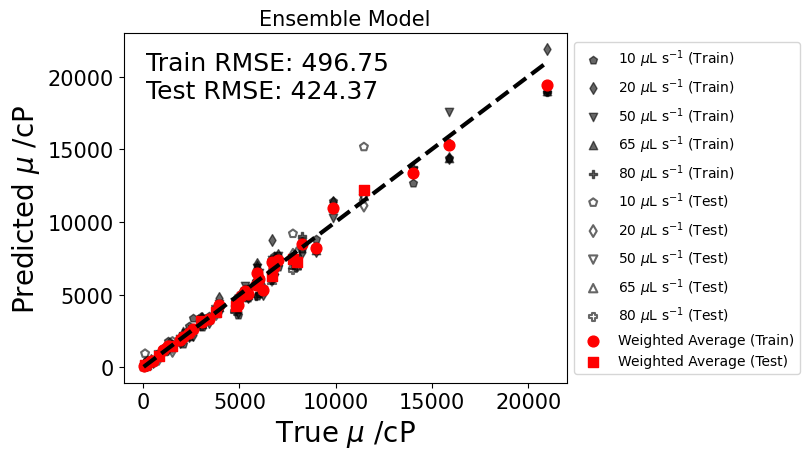

In [15]:
# Calculate weighted averages of predictions
weights = {flow: 1 / results[flow]['train_rmse'] for flow in flowrates}
total_weight = sum(weights.values())
u = {flow: weights[flow] / total_weight for flow in flowrates}

# Calculate weighted average predictions for train and test
train_predictions_avg = sum(u[flow] * results[flow]['train_predictions'] for flow in flowrates)
test_predictions_avg = sum(u[flow] * results[flow]['test_predictions'] for flow in flowrates)

# Compute overall prediction errors
average_train_mse = metrics.mean_squared_error(np.exp(train_test_data[80][2]), np.exp(train_predictions_avg))
average_test_mse = metrics.mean_squared_error(np.exp(train_test_data[80][3]), np.exp(test_predictions_avg))
average_train_rmse = np.sqrt(average_train_mse)
average_test_rmse = np.sqrt(average_test_mse)

# Plot train and test predictions together with weighted average
plt.figure(figsize=(10, 5), dpi=100)

# Plot training predictions with black markers
for flow in flowrates:
    plt.scatter(np.exp(train_test_data[flow][2]), np.exp(results[flow]['train_predictions']),
                marker=results[flow]['marker'], color='black', alpha=0.6,
                label=f'{flow} $\mu$L s$^{{-1}}$ (Train)')

# Plot testing predictions with original colors and different edge markers
for flow in flowrates:
    plt.scatter(np.exp(train_test_data[flow][3]), np.exp(results[flow]['test_predictions']),
                marker=results[flow]['marker'], edgecolor='black', facecolor='none',
                linewidth=1.5, alpha=0.6, label=f'{flow} $\mu$L s$^{{-1}}$ (Test)')

# Highlight weighted average predictions with different markers
plt.scatter(np.exp(train_test_data[80][2]), np.exp(train_predictions_avg),
            color='red', marker='o', s=60, label='Weighted Average (Train)')
plt.scatter(np.exp(train_test_data[80][3]), np.exp(test_predictions_avg),
            color='red', marker='s', s=60, label='Weighted Average (Test)')

# Add diagonal reference line
plt.plot([y_dict[80].min(), y_dict[80].max()], [y_dict[80].min(), y_dict[80].max()], 'k--', lw=3)

# Position the legend outside the plot
plt.legend(fontsize=10, loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)

# Display RMSE values on the plot
plt.text(0.05, 0.95, f'Train RMSE: {average_train_rmse:.2f}\nTest RMSE: {average_test_rmse:.2f}',
         horizontalalignment='left', verticalalignment='top',
         transform=plt.gca().transAxes, fontsize=18)

# Update labels and title
plt.xlabel('True $\mu$ /cP')
plt.ylabel('Predicted $\mu$ /cP')
plt.title('Ensemble Model', fontsize=15)

# Adjust layout to make room for the legend
plt.tight_layout(rect=[0, 0, 0.85, 1])

# Show plot
plt.show()

### Analytical model

##### Set physical parameters

In [16]:
# Set dispense flow rate Q_l
Q_set = 80           # uL/s

# Define pipette tip geometry
r_in = 2.5e-3        # m
r_out = 0.9e-3       # m
length = 16e-3       # m

# Calculate apparent shear rate prefactor
shear_prefactor = 4/(np.pi*(r_out**3))     # 1/m^3 (shear rate = shear_prefactor * Q)

# Calculate beta (n = 1)
beta = np.tan((r_in-r_out)/length) * (3/2) * (1/shear_prefactor) * (1/(1-(r_out/r_in)**3))  # m^3 (Q = delta_P * beta/viscosity)
beta_p = 1/beta # 1/m^3 (delta_P = beta_p * viscosity * Q)

##### Set model parameters

In [17]:
V_0 = 8000e-9      # m^3, initial volume
P_0 = 95000        # Pa, initial pressure
P_atm = 101325     # Pa

In [18]:
# Calculate Q_s (plunger speed)
def calculate_Qs(Q_set):
    r_plunger = 3e-3  # m 
    transfer_v = 1013.9597
    transfer_m = 0.0001
    transfer_b = 27.2644
    transfer_plunger = transfer_v * transfer_m + transfer_b  # ul/mm (from Opentrons documentation)

    Q_s = np.pi * r_plunger**2 * (Q_set / transfer_plunger)*10**-3  # m^3/s
    return Q_s

Q_s = calculate_Qs(Q_set)

##### Define fluid properties (example: power-law fluid)

In [19]:
# Power-law fluid parameters
n = 0.9
K = 5000e-3  # Pa s

##### Define model

In [20]:
# Prefactor C
def prefactor_c(n, K): 
    C = (4/(np.pi*r_out**3))**n * (((3*n)+1)/(4*n))**n * (2*K/(3*n*np.tan((r_in-r_out)/length))) * (1-(r_out/r_in)**(3*n))
    return C

In [21]:
# Define the ODE to solve
def drdt(t, r, n, K, C, V_0, Q_s):
    return (r + P_atm)**2 / (V_0 * P_0) * (Q_s - ((r / C)**(1/n)))

In [22]:
# Model function that computes V_t based on n and K
def model_V(n, K, V_0, Q_s, t_eval):
    # Compute prefactor C
    C = prefactor_c(n, K)

    # Solve the differential equation
    s0 = 1e-8  # small non-zero initial condition for stability
    t_span = (t_eval[0], t_eval[-1])  # Set time span based on experimental data

    # Solve using a stiff solver (BDF)
    sol = solve_ivp(drdt, t_span, [s0], args=(n, K, C, V_0, Q_s), t_eval=t_eval, method='BDF')

    # Extract the solution for s(t)
    r_t = sol.y.flatten()

    # Compute the flow rate Q(t)
    Q_t = (r_t / C)**(1/n)

    # Compute the cumulative volume dispensed V(t)
    V_model = cumtrapz(Q_t, t_eval, initial=0)

    return V_model * 10**9  # Convert to uL

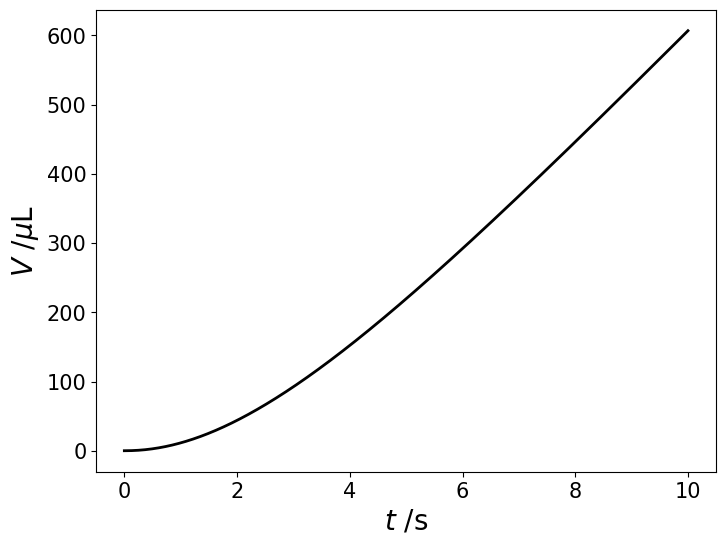

In [23]:
# Define the experimental time points
t_exp = np.linspace(0, 10, 1000) 

# Call the model_V function to compute V(t)
V_t = model_V(n, K, V_0, Q_s, t_exp)

# Plot the results
plt.figure(figsize=(8, 6))
plt.plot(t_exp, V_t, 'k-', linewidth = 2)
plt.xlabel('$t$ /s')
plt.ylabel('$V$ /$\mu$L')
plt.show()

### Fit analytical model to experimental data

#### Newtonian liquid

##### Import Newtonian liquid data

In [24]:
# Load the csv file
df = pd.read_csv('Experimental data for comparison_FR80.csv')
experimental_data = df.to_numpy()

In [25]:
# Analytical solution
def theory_curve(y, params):
    mu, tau = params
    c = (P_atm / (Q_s * beta_p * mu)) + 1
    
    eqn = ((np.log((c-y)/(y*(c-1)))-(c/(c-y))+(c/(c-1)))/c**2)-tau
    return eqn

##### Comparison between model and experimental data

C:\Users\sohwy\AppData\Local\Temp\ipykernel_22732\2136388049.py:6: RuntimeWarning: invalid value encountered in log
  eqn = ((np.log((c-y)/(y*(c-1)))-(c/(c-y))+(c/(c-1)))/c**2)-tau
c:\Users\sohwy\Anaconda3\envs\viscometer\Lib\site-packages\scipy\optimize\_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


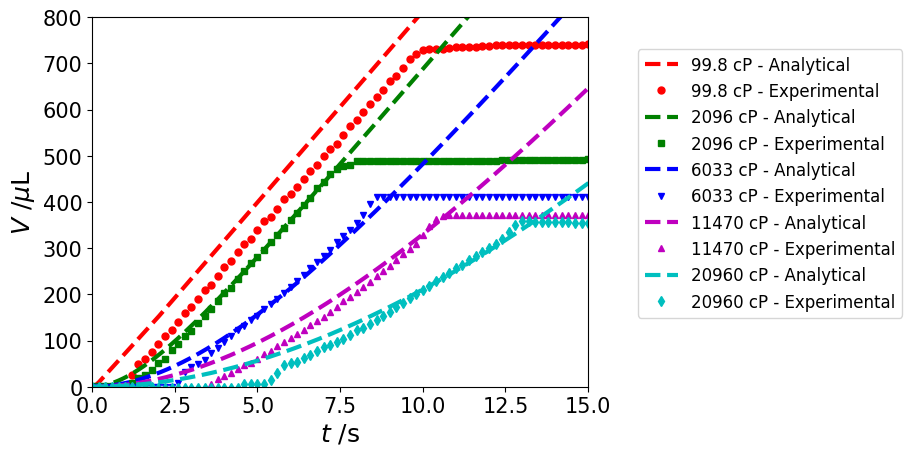

In [33]:
# Viscosities for comparison
visc_compare = np.array([99.8,2096,6033,11470,20960])*1e-3    # Pa s

# Set tau range for each viscosity
tau_upper = [0.001, 0.005, 0.01, 0.05, 0.05] 

# Define colors and markers for each viscosity
colors = ['r', 'g', 'b', 'm', 'c']
markers = ['o', 's', 'v', '^', 'd']

# Format labels for viscosity
visc_labels = [int(v) if v.is_integer() else v for v in visc_compare*1e3]

for i, visc in enumerate(visc_compare):
    # Define tau range for the specific viscosity
    tau = np.linspace(0, tau_upper[i], 1001)
    y = np.zeros(np.size(tau))
    
    for j in range(np.size(tau)):
        params = [visc, tau[j]]
        initial_guess = 0.05 if j < 20 else 10**-100
        y[j] = fsolve(theory_curve, initial_guess, params)
    
    # Calculate time and flow rates
    t = tau * (P_0 * V_0) * (1 / (beta_p * visc * Q_s**2))
    Q_l = (1 - y) * Q_s

    # Calculate cumulative volume dispensed
    V_l = cumtrapz(Q_l, t, initial=0)

    # Plot both theoretical and experimental curves
    plt.plot(t, V_l * 10**9, f'{colors[i]}', linestyle='--',linewidth=3,label=f'{visc_labels[i]} cP - Analytical')
    plt.plot(experimental_data[:, 0], experimental_data[:, i + 1] * 10**3, f'{colors[i]}{markers[i]}', markersize=5, linestyle='None', label=f'{visc_labels[i]} cP - Experimental')

# Set plot limits and labels
plt.xlim([0, 15])
plt.ylim([0, 800])
plt.xlabel('$t$ /s',fontsize=18)
plt.ylabel('$V$ /$\mu$L',fontsize=18)
#plt.title('Flowrate = 80 $\mu$L $s^{-1}$',fontsize=14)

# Legend
plt.legend(loc='right', bbox_to_anchor=(1.65, 0.55), fontsize=12)

plt.show()

#### Power-law fluid

##### Import molasses data

In [27]:
# Load the csv file
df = pd.read_csv('Experimental data for comparison_Molasses.csv')
molasses_data = df.to_numpy()

##### Select flowrates for comparison and fitting region

In [28]:
# Flow rates
fr_compare = [50,65,80]

# Time range to fit over
t_fit = np.arange(0,9.2,0.2)

In [29]:
def exp_fit(V_exp, t_fit):
    fit_region = np.size(t_fit)
    return V_exp[0:fit_region]

##### Define loss function

In [30]:
# Loss function
def loss(params, V_exp, V_0, Q_s, t_fit):
    n, log_K = params
    K = np.exp(log_K)
    V_model = model_V(n, K, V_0, Q_s, t_fit)

    # L2 regularization to prevent overly large values of `K`
    regularization_weight = 100.0  # Adjust this weight to balance the regularization
    penalty = regularization_weight * (K**2)  # L2 regularization on `K`

    # Return the loss with both regularization terms
    return np.sum((V_exp - V_model)**2) + penalty 

##### Sensitivity analysis for error estimation

In [31]:
# Define the perturbation function to estimate confidence intervals
def perturbation_confidence_intervals(best_fit_params, loss_func, args, perturbation_fraction=0.05, confidence_delta=3.84):
    ci_lower = []
    ci_upper = []

    # Calculate the original loss
    original_loss = loss_func(best_fit_params, *args)

    for i in range(len(best_fit_params)):
        param = best_fit_params[i]

        # Perturb the parameter downwards
        perturbed_params = best_fit_params.copy()
        perturbed_params[i] = param * (1 - perturbation_fraction)
        perturbed_loss = loss_func(perturbed_params, *args)

        # Increase parameter until loss exceeds confidence_delta
        while perturbed_loss - original_loss <= confidence_delta:
            perturbed_params[i] *= (1 - perturbation_fraction)
            perturbed_loss = loss_func(perturbed_params, *args)
        ci_lower.append(perturbed_params[i])

        # Reset parameter to best-fit value
        perturbed_params[i] = param

        # Perturb the parameter upwards
        perturbed_params[i] = param * (1 + perturbation_fraction)
        perturbed_loss = loss_func(perturbed_params, *args)

        # Increase parameter until loss exceeds confidence_delta
        while perturbed_loss - original_loss <= confidence_delta:
            perturbed_params[i] *= (1 + perturbation_fraction)
            perturbed_loss = loss_func(perturbed_params, *args)
        ci_upper.append(perturbed_params[i])

    return np.array(ci_lower), np.array(ci_upper)

##### Minimize loss function and extract fitted power-law parameters

C:\Users\sohwy\AppData\Local\Temp\ipykernel_22732\1222372845.py:3: RuntimeWarning: invalid value encountered in power
  return (r + P_atm)**2 / (V_0 * P_0) * (Q_s - ((r / C)**(1/n)))


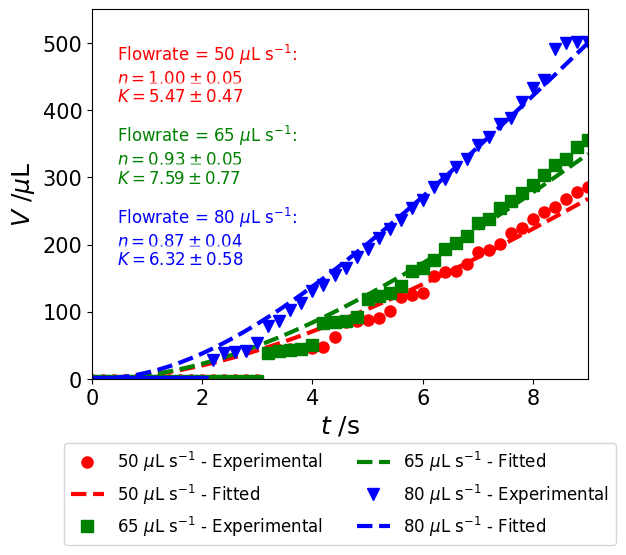

In [32]:
colors = ['r', 'g', 'b']
markers = ['o', 's', 'v']

# Fit analytical model to experimental data at different flowrates
for i in range(np.size(fr_compare)):
    # Define bounds for fitting parameters
    bounds = [(0.1, 1), (np.log(1e-3), np.log(10000e-3))]

    # Calculate Q_s depending on flowrate
    Q_s = calculate_Qs(fr_compare[i])

    # Fit data using differential evolution method
    result = differential_evolution(loss, bounds=bounds, args=(exp_fit(molasses_data[:,i+1]*10**3,t_fit), V_0, Q_s, t_fit))
    
    # Extract best-fit parameters
    n_fit, K_fit_log = result.x
    K_fit = np.exp(K_fit_log)

    # Estimate confidence intervals using sensitivity analysis
    ci_lower, ci_upper = perturbation_confidence_intervals(result.x, loss, 
                                                           args=(exp_fit(molasses_data[:,i+1]*10**3,t_fit), V_0, Q_s, t_fit))

    # Plot experimental data
    plt.plot(t_fit, exp_fit(molasses_data[:,i+1]*10**3,t_fit), f'{colors[i]}{markers[i]}', 
             markersize=8, linestyle='None', label=f'{fr_compare[i]} $\mu$L s$^{{-1}}$ - Experimental')

    # Plot fitted data
    V_fit = model_V(n_fit, K_fit, V_0, Q_s, t_fit)  
    plt.plot(t_fit, V_fit, f'{colors[i]}--', linewidth=3, label=f'{fr_compare[i]} $\mu$L s$^{{-1}}$ - Fitted')

    # Annotate fitted parameters and confidence intervals
    n_ci = (ci_upper[0] - ci_lower[0]) / 2
    K_ci = (np.exp(ci_upper[1]) - np.exp(ci_lower[1])) / 2

    # Adjust text position
    y_position_n = 0.8 - i * 0.22
    y_position_K = 0.75 - i * 0.22

    plt.text(0.05, y_position_n, f'Flowrate = {fr_compare[i]} $\mu$L s$^{{-1}}$:\n$n = {n_fit:.2f} \pm {n_ci:.2f}$', 
             transform=plt.gca().transAxes, fontsize=12, color=colors[i], 
             bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))
    
    plt.text(0.05, y_position_K, f'$K = {K_fit:.2f} \pm {K_ci:.2f}$', 
             transform=plt.gca().transAxes, fontsize=12, color=colors[i], 
             bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))

# Set plot limits and labels
plt.xlim([0, 9])
plt.ylim([0, 550])
plt.xlabel('$t$ /s',fontsize=18)
plt.ylabel('$V$ /$\mu$L',fontsize=18)

# Add legend
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2, fontsize=12)

# Show plot
plt.show()
